import sys
!{sys.executable} -m pip install xgboost

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
#import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load and inspect data
df = pd.read_csv(r"D:\desktop - new\Bitcoin\bitcoin_data.csv")

print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)



Data shape: (3072, 6)

First few rows:
       Date        Close         High          Low         Open       Volume
0  1/1/2017   998.325012  1003.080017   958.698975   963.658020  147775008.0
1  1/2/2017  1021.750000  1031.390015   996.702026   998.617004  222184992.0
2  1/3/2017  1043.839966  1044.079956  1021.599976  1021.599976  185168000.0
3  1/4/2017  1154.729980  1159.420044  1044.400024  1044.400024  344945984.0
4  1/5/2017  1013.380005  1191.099976   910.416992  1156.729980  510199008.0

Data types:
Date       object
Close     float64
High      float64
Low       float64
Open      float64
Volume    float64
dtype: object


In [2]:
df['Date']= pd.to_datetime(df['Date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3072 non-null   datetime64[ns]
 1   Close   3072 non-null   float64       
 2   High    3072 non-null   float64       
 3   Low     3072 non-null   float64       
 4   Open    3072 non-null   float64       
 5   Volume  3072 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 144.1 KB


In [4]:
df.head(10)

,Date,Close,High,Low,Open,Volume
0,2017-01-01,998.325012,1003.080017,958.698975,963.658020,147775008.0
1,2017-01-02,1021.750000,1031.390015,996.702026,998.617004,222184992.0
2,2017-01-03,1043.839966,1044.079956,1021.599976,1021.599976,185168000.0
3,2017-01-04,1154.729980,1159.420044,1044.400024,1044.400024,344945984.0
4,2017-01-05,1013.380005,1191.099976,910.416992,1156.729980,510199008.0
5,2017-01-06,902.200989,1046.810059,883.943970,1014.239990,351876000.0
6,2017-01-07,908.585022,908.585022,823.556030,903.487000,279550016.0
7,2017-01-08,911.198975,942.723999,887.249023,908.174988,158715008.0
8,2017-01-09,902.828003,913.685974,879.807007,913.244019,141876992.0
9,2017-01-10,907.679016,914.872986,901.059998,902.440002,115808000.0


In [5]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2017-01-01,998.325012,1003.080017,958.698975,963.658020,147775008.0
1,2017-01-02,1021.750000,1031.390015,996.702026,998.617004,222184992.0
2,2017-01-03,1043.839966,1044.079956,1021.599976,1021.599976,185168000.0
3,2017-01-04,1154.729980,1159.420044,1044.400024,1044.400024,344945984.0
4,2017-01-05,1013.380005,1191.099976,910.416992,1156.729980,510199008.0


# Step 2: Data Preprocessing and Date Conversion

# Step 3: Calculate Volatility and Returns

In [6]:
# Calculate daily returns
df['Returns'] = df['Close'].pct_change()
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Calculate different volatility measures
df['Volatility_1d'] = df['Returns'].rolling(window=1).std()
df['Volatility_7d'] = df['Returns'].rolling(window=7).std()
df['Volatility_30d'] = df['Returns'].rolling(window=30).std()

# Target variable: Future 7-day volatility (what we want to predict)
df['Target_Volatility'] = df['Volatility_7d'].shift(-7)

print("Volatility statistics:")
print(df[['Volatility_1d', 'Volatility_7d', 'Volatility_30d']].describe())

Volatility statistics:
       Volatility_1d  Volatility_7d  Volatility_30d
count            0.0    3065.000000     3042.000000
mean             NaN       0.031698        0.033894
std              NaN       0.018817        0.014275
min              NaN       0.001998        0.008887
25%              NaN       0.019143        0.024335
50%              NaN       0.027489        0.030984
75%              NaN       0.039930        0.040215
max              NaN       0.158796        0.091330


In [7]:
df.head(10)

,Date,Close,High,Low,Open,Volume,Returns,Log_Returns,Volatility_1d,Volatility_7d,Volatility_30d,Target_Volatility
0,2017-01-01,998.325012,1003.080017,958.698975,963.658020,147775008.0,NaN,NaN,NaN,NaN,NaN,0.080276
1,2017-01-02,1021.750000,1031.390015,996.702026,998.617004,222184992.0,0.023464,0.023193,NaN,NaN,NaN,0.078936
2,2017-01-03,1043.839966,1044.079956,1021.599976,1021.599976,185168000.0,0.021620,0.021389,NaN,NaN,NaN,0.077920
3,2017-01-04,1154.729980,1159.420044,1044.400024,1044.400024,344945984.0,0.106233,0.100960,NaN,NaN,NaN,0.068576
4,2017-01-05,1013.380005,1191.099976,910.416992,1156.729980,510199008.0,-0.122410,-0.130575,NaN,NaN,NaN,0.067693
5,2017-01-06,902.200989,1046.810059,883.943970,1014.239990,351876000.0,-0.109711,-0.116209,NaN,NaN,NaN,0.059944
6,2017-01-07,908.585022,908.585022,823.556030,903.487000,279550016.0,0.007076,0.007051,NaN,NaN,NaN,0.059468
7,2017-01-08,911.198975,942.723999,887.249023,908.174988,158715008.0,0.002877,0.002873,NaN,0.080276,NaN,0.059526
8,2017-01-09,902.828003,913.685974,879.807007,913.244019,141876992.0,-0.009187,-0.009229,NaN,0.078936,NaN,0.060277
9,2017-01-10,907.679016,914.872986,901.059998,902.440002,115808000.0,0.005373,0.005359,NaN,0.077920,NaN,0.071732


In [8]:
df= df.drop('Volatility_1d', axis=1)

# Step 4: Feature Engineering

In [9]:
def create_features(df):
    """Create technical indicators and features"""
    
    # Price-based features
    df['Price_Range'] = (df['High'] - df['Low']) / df['Close']
    df['Price_Change'] = df['Close'].pct_change()
    df['Gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
    
    # Moving averages
    for window in [5, 10, 20, 50]:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'MA_Ratio_{window}'] = df['Close'] / df[f'MA_{window}']
    
    # Volatility features
    df['HL_Ratio'] = df['High'] / df['Low']
    df['OC_Ratio'] = df['Open'] / df['Close']
    
    # Volume features
    df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_20']
    df['Volume_Change'] = df['Volume'].pct_change()
    
    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # Momentum indicators
    df['Momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
    
    # Lagged features
    for lag in [1, 2, 3, 5, 7]:
        df[f'Returns_lag_{lag}'] = df['Returns'].shift(lag)
        df[f'Volatility_lag_{lag}'] = df['Volatility_7d'].shift(lag)
        df[f'Volume_lag_{lag}'] = df['Volume'].shift(lag)
    
    # Rolling statistics
    df['Roll_Mean_7'] = df['Close'].rolling(window=7).mean()
    df['Roll_Std_7'] = df['Close'].rolling(window=7).std()
    df['Roll_Skew_7'] = df['Close'].rolling(window=7).skew()
    
    return df

# Apply feature engineering
df = create_features(df)
print(f"Total features created: {len(df.columns)}")

Total features created: 54


# Step 5: Prepare Features and Target

In [10]:
# Define feature columns (excluding date and target)
exclude_columns = ['Date', 'Target_Volatility']
feature_columns = [col for col in df.columns if col not in exclude_columns]

print(f"Number of features: {len(feature_columns)}")
print("Feature columns:", feature_columns)

# Remove rows with NaN values (from rolling calculations and lags)
df_clean = df.dropna().copy()

print(f"Clean data shape: {df_clean.shape}")

# Prepare X and y
X = df_clean[feature_columns]
y = df_clean['Target_Volatility']

# Feature selection - select top 30 features
selector = SelectKBest(score_func=f_regression, k=min(30, len(feature_columns)))
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]

print(f"\nSelected {len(selected_features)} features:")
print(selected_features.tolist())

X = X[selected_features]

Number of features: 52
Feature columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Log_Returns', 'Volatility_7d', 'Volatility_30d', 'Price_Range', 'Price_Change', 'Gap', 'MA_5', 'MA_Ratio_5', 'MA_10', 'MA_Ratio_10', 'MA_20', 'MA_Ratio_20', 'MA_50', 'MA_Ratio_50', 'HL_Ratio', 'OC_Ratio', 'Volume_MA_5', 'Volume_MA_20', 'Volume_Ratio', 'Volume_Change', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Momentum_5', 'Momentum_10', 'Returns_lag_1', 'Volatility_lag_1', 'Volume_lag_1', 'Returns_lag_2', 'Volatility_lag_2', 'Volume_lag_2', 'Returns_lag_3', 'Volatility_lag_3', 'Volume_lag_3', 'Returns_lag_5', 'Volatility_lag_5', 'Volume_lag_5', 'Returns_lag_7', 'Volatility_lag_7', 'Volume_lag_7', 'Roll_Mean_7', 'Roll_Std_7', 'Roll_Skew_7']
Clean data shape: (3016, 54)

Selected 30 features:
['Close', 'High', 'Low', 'Open', 'Log_Returns', 'Volatility_7d', 'Volatility_30d', 'Price_Range', 'MA_5', 'MA_Ratio_5', 'MA_10', 'MA_Ratio_10', 'MA_20', 'MA_50', 'MA_Ratio_50'

# Step 6: Train-Test Split (Time Series)

In [11]:
# For time series, we split chronologically
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]
dates_test = df_clean['Date'].iloc[split_index:]

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Test period: {dates_test.min()} to {dates_test.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Also create MinMax scaled version for some models
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

Training set: 2412 samples
Test set: 604 samples
Test period: 2023-09-28 00:00:00 to 2025-05-23 00:00:00


# Step 7: Define and Train Machine Learning Models

In [12]:
def train_models(X_train, X_test, y_train, y_test):
    """Train multiple ML models and return predictions"""
    
    models = {}
    predictions = {}
    model_scores = {}
    
    # 1. Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    models['Linear Regression'] = lr
    predictions['Linear Regression'] = lr.predict(X_test)
    
    # 2. Ridge Regression
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    models['Ridge'] = ridge
    predictions['Ridge'] = ridge.predict(X_test)
    
    # 3. Lasso Regression
    lasso = Lasso(alpha=0.01)
    lasso.fit(X_train, y_train)
    models['Lasso'] = lasso
    predictions['Lasso'] = lasso.predict(X_test)
    
    # 4. Random Forest
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    models['Random Forest'] = rf
    predictions['Random Forest'] = rf.predict(X_test)
    
    # 5. Gradient Boosting
    #gb = GradientBoostingRegressor(
        #n_estimators=100,
        #learning_rate=0.1,
       # max_depth=5,
        #random_state=42
    #)
    #gb.fit(X_train, y_train)
    #models['Gradient Boosting'] = gb
    #predictions['Gradient Boosting'] = gb.predict(X_test)
    
    # 6. XGBoost
    #xg_reg = xgb.XGBRegressor(
        #n_estimators=100,
        #learning_rate=0.1,
        #max_depth=6,
        #random_state=42,
        #n_jobs=-1
    #)
    #xg_reg.fit(X_train, y_train)
    #models['XGBoost'] = xg_reg
    #predictions['XGBoost'] = xg_reg.predict(X_test)
    
    # 7. Support Vector Regression
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_train_minmax, y_train)  # SVR works better with MinMax scaling
    models['SVR'] = svr
    predictions['SVR'] = svr.predict(X_test_minmax)
    
    return models, predictions

# Train all models
models, predictions = train_models(X_train_scaled, X_test_scaled, y_train, y_test)
print("All models trained successfully!")

All models trained successfully!


# Step 8: Model Evaluation

In [13]:
def evaluate_models(y_true, predictions, models, X_train, y_train):
    """Comprehensive model evaluation"""
    
    results = {}
    
    for model_name, y_pred in predictions.items():
        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        
        # Calculate mean absolute percentage error
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        # Store results
        results[model_name] = {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape
        }
        
        print(f"{model_name}:")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  R²: {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        print()
    
    return pd.DataFrame(results).T

# Evaluate models
results_df = evaluate_models(y_test, predictions, models, X_train_scaled, y_train)

# Find best model
best_model_name = results_df['RMSE'].idxmin()
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

# Cross-validation for best model
tscv = TimeSeriesSplit(n_splits=3)
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, 
                          cv=tscv, scoring='neg_mean_squared_error')
print(f"Cross-validation RMSE: {np.sqrt(-cv_scores.mean()):.6f} (+/- {np.sqrt(cv_scores.std()):.6f})")

Linear Regression:
  RMSE: 0.011381
  MAE: 0.009241
  R²: -0.0908
  MAPE: 47.35%

Ridge:
  RMSE: 0.011292
  MAE: 0.009205
  R²: -0.0738
  MAPE: 46.99%

Lasso:
  RMSE: 0.013869
  MAE: 0.012018
  R²: -0.6199
  MAPE: 68.91%

Random Forest:
  RMSE: 0.012445
  MAE: 0.010421
  R²: -0.3042
  MAPE: 56.01%

SVR:
  RMSE: 0.056616
  MAE: 0.055557
  R²: -25.9925
  MAPE: 289.52%

Best model: Ridge
Cross-validation RMSE: 0.019225 (+/- 0.010827)


# Step 9: Feature Importance Analysis

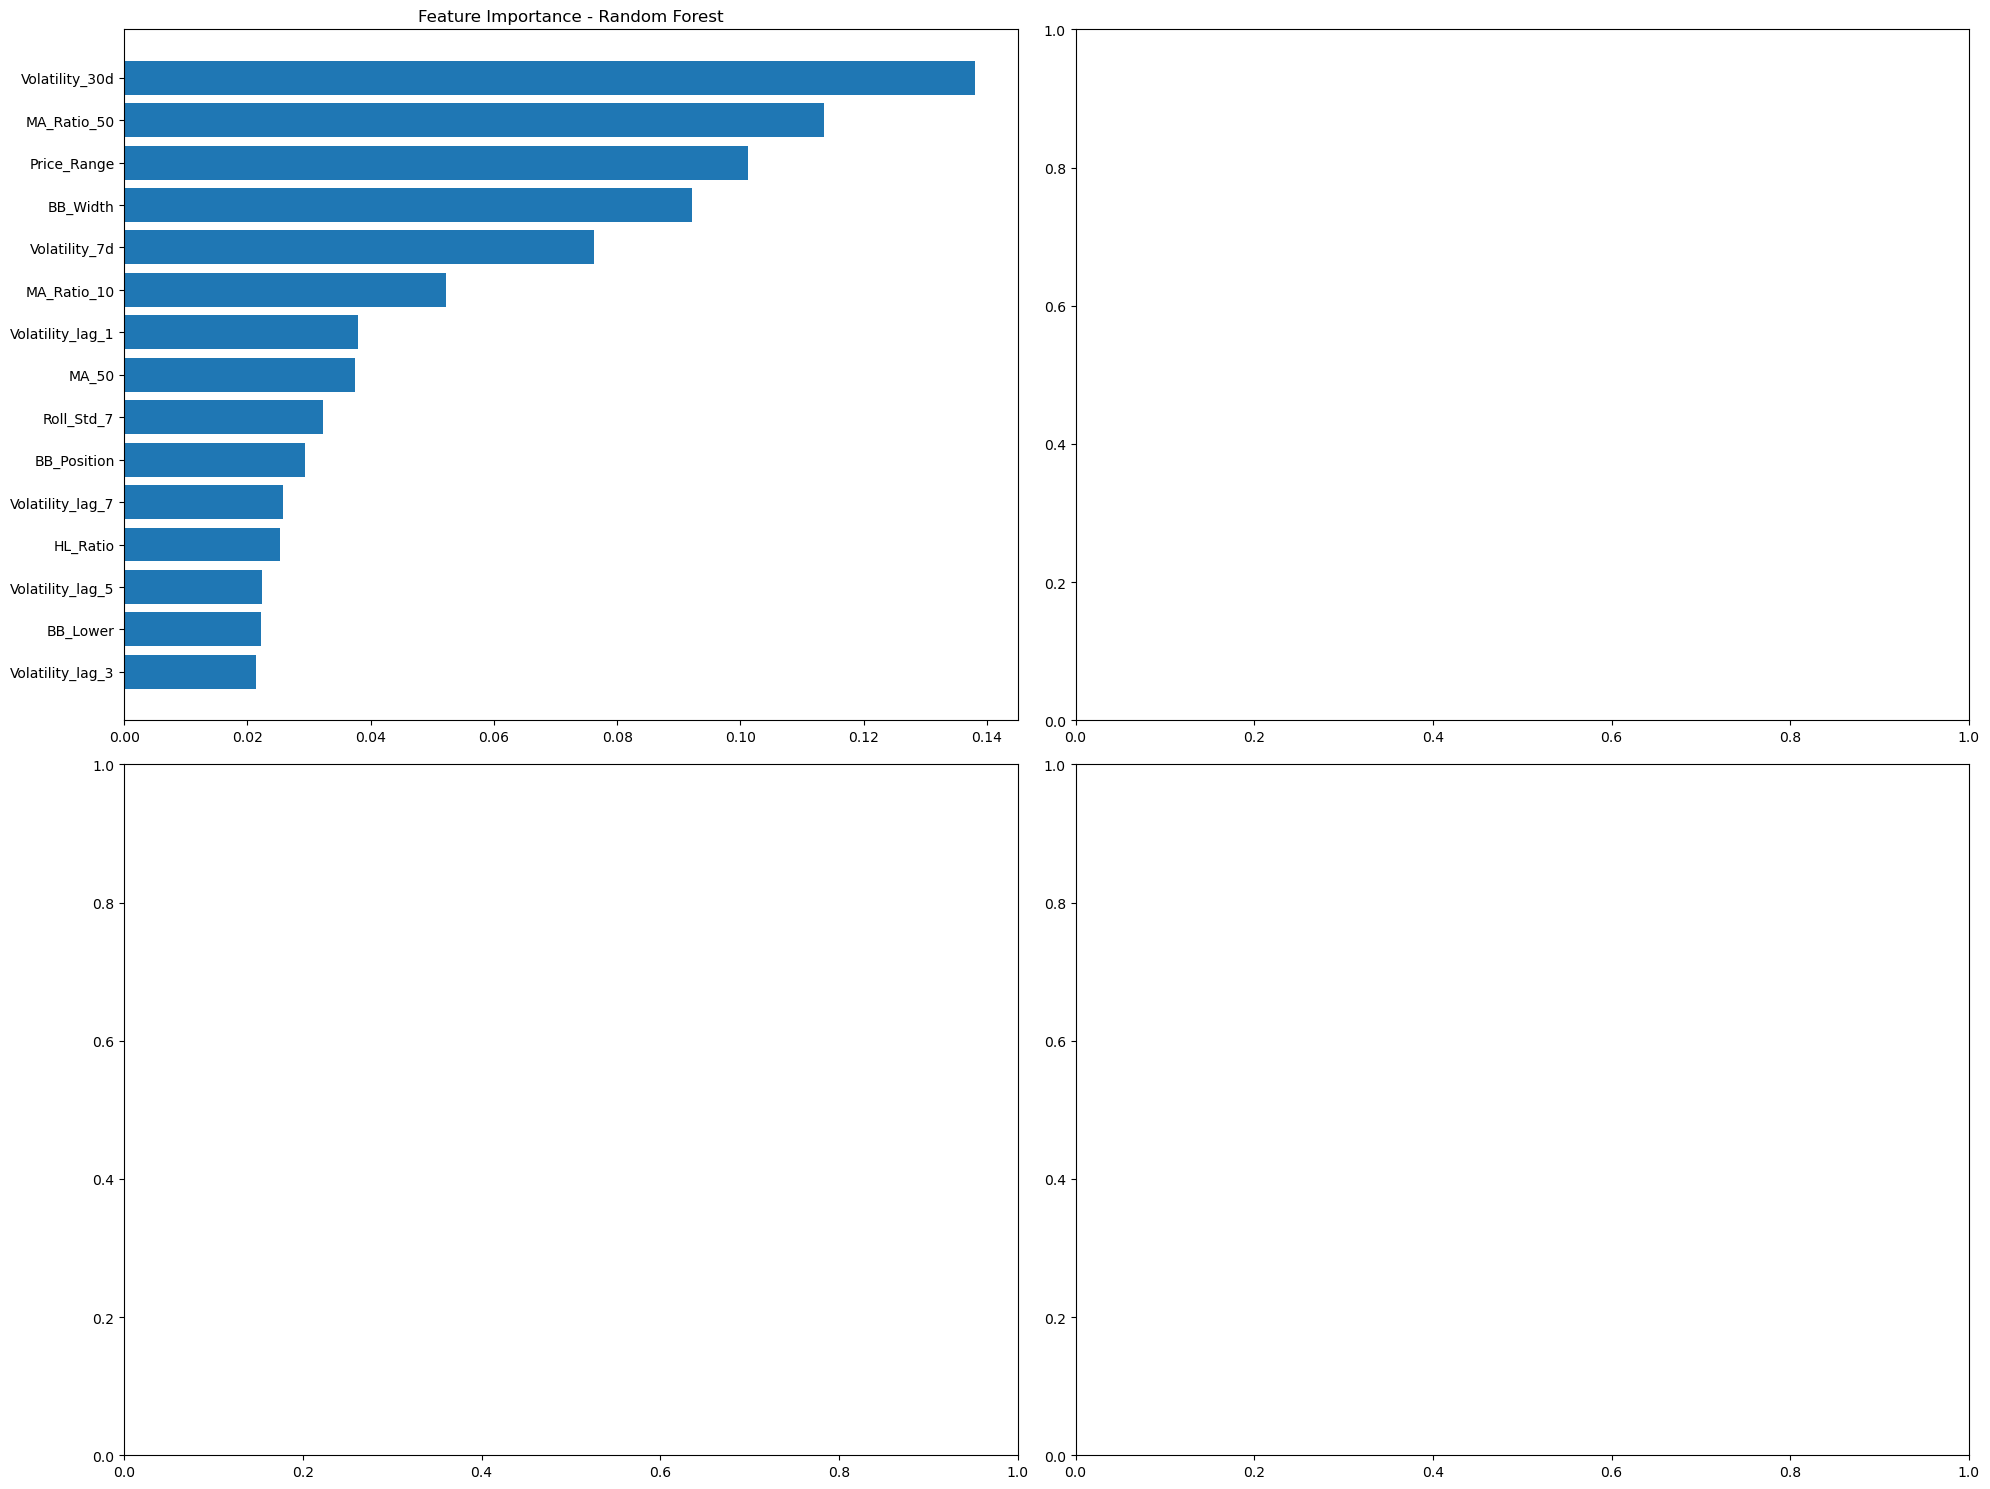

In [14]:
def plot_feature_importance(models, feature_names, top_n=15):
    """Plot feature importance for tree-based models"""
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.ravel()
    
    tree_models = {
        'Random Forest': models.get('Random Forest'),
        'Gradient Boosting': models.get('Gradient Boosting'), 
        'XGBoost': models.get('XGBoost')
    }
    
    for idx, (name, model) in enumerate(tree_models.items()):
        if model is not None:
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                indices = np.argsort(importances)[-top_n:]
                
                axes[idx].barh(range(len(indices)), importances[indices])
                axes[idx].set_yticks(range(len(indices)))
                axes[idx].set_yticklabels([feature_names[i] for i in indices])
                axes[idx].set_title(f'Feature Importance - {name}')
    
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(models, selected_features)

# Detailed feature importance for best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))